# Interactive Dashboard

## Load the models

In [1]:
# pip install panel altair

In [2]:
# For loading the LSTM model
from tensorflow.keras.models import load_model
# For loading the RidgeRegressor Model
from skforecast.utils import load_forecaster

import panel as pn
import altair as alt
from altair import datum
import datetime as dt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format
import pandas as pd
import numpy as np
pn.extension()
alt.renderers.enable("default")

warnings.filterwarnings("ignore")
write_config = {
    "uri": "mongodb://localhost:27017/CA2.raw_tweets?retryWrites=true&w=majority",
    "database": "CA2",
    "raw_collection": "raw_tweets",
    "modified_collection": "modified_tweets",
    "aggregates_collection": "daily_data",
    "writeConcern.w": "majority"
}

2023-11-16 14:12:29.114587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 14:12:29.325318: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 14:12:29.325348: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 14:12:29.326797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 14:12:29.446178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 14:12:29.447436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
hourlyDataSparkDF = spark.read\
    .format("mongodb")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", "hourly_data_imputed")\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .load()\
    .sort("date")
hourlyDataDF = hourlyDataSparkDF.withColumn("date", date_format("date", "yyyy-MM-dd HH:mm:ss")).toPandas()
hourlyDataDF['date'] = pd.to_datetime(hourlyDataDF['date'], format='ISO8601')
hourlyDataDF.set_index("date", inplace=True)
hourlyDataDF = hourlyDataDF.asfreq('H')
hourlyDataDF.drop("_id", axis=1, inplace=True)
hourlyDataDF.drop("average_sentiment", axis=1, inplace=True)
hourlyDataDF.drop("negative_tweet_ratio", axis=1, inplace=True)
hourlyDataDF.drop("neutral_tweet_ratio", axis=1, inplace=True)
hourlyDataDF.drop("positive_tweet_ratio", axis=1, inplace=True)
hourlyDataDF.drop("negative_tweet_ratio_knn", axis=1, inplace=True)
hourlyDataDF.drop("neutral_tweet_ratio_knn", axis=1, inplace=True)
hourlyDataDF.drop("positive_tweet_ratio_knn", axis=1, inplace=True)

In [4]:
# Ridge Regression Model
ridge3MModel = load_forecaster('ridge3MModel.py', verbose=True)

ForecasterAutoregMultiVariate 
Regressor: Ridge(alpha=1, random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 24 
Target series, level: average_sentiment_knn 
Multivariate series (names): ['average_sentiment_knn', 'negative_tweet_ratio_knn', 'neutral_tweet_ratio_knn', 'positive_tweet_ratio_knn'] 
Maximum steps predicted: 1503 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-25 12:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-11-14 22:56:17 
Last fit date: 2023-11-14 23:19:40 
Skforecast 

In [64]:
lookback = 336
forecast = 168

def LSTMPredict(forecast):
    # temp dataframe
    df = pd.DataFrame(columns=["average_sentiment_knn"])
    # get the last timestamp from the available data
    lastTimeStamp = hourlyDataDF.iloc[-1:].index.values[0]
    #get the sentiment of the last 24 rows
    previous = hourlyDataDF.iloc[-lookback:].values
    previous = previous.reshape(1, lookback, 1)
    print(previous)
    predicited = list()
    # Loop until the end of the forecasted date
    for i in range(forecast + 1):
        predictions = LSTM.predict(previous, verbose=False).reshape(-1, 1)
        print(predictions.shape, predictions.shape[0], predictions[0][0])
        # Remove the last 1
        for l in range(predictions.shape[0]):
            index = pd.to_datetime(lastTimeStamp, format="%Y-%m-%d %H:%M:%S") + dt.timedelta(hours=l)
            df.loc[index] = { "average_sentiment_knn": predictions[l][0] }
        break
#         # Reshape first the inputs
#         a = np.reshape(previous, (1, 24))
# #         print(a)
#         # Start prediction
#         prediction = LSTM.predict(a, verbose=False)
#         #Get the predicted value
#         newPrediction = np.reshape(prediction, (1))[0]
#         # remove the first element of the array
#         previous.pop(0)
#         # add the newly predicted value. This will make the input still equal to 24
#         previous.append(newPrediction)
#         # Add to the dataframe with the timestamp index
#         index = pd.to_datetime(lastTimeStamp, format="%Y-%m-%d %H:%M:%S") + dt.timedelta(hours=i)
#         df.loc[index] = { "average_sentiment_knn": newPrediction }
    return df

After loading the LSTM, predict the values up to 3 months so that it will not keep on repeating the prediction when the input changes in the dashboard. Predicting through LSTM can take some time to finish especially with this large input

In [65]:
LSTM = load_model("LSTMMultiDay")
predicted = LSTMPredict(13)

[[[ 0.1258125 ]
  [ 0.12370213]
  [ 0.12370693]
  [ 0.12371186]
  [ 0.12371692]
  [ 0.12372213]
  [ 0.12372749]
  [ 0.12373299]
  [ 0.12373866]
  [ 0.1237445 ]
  [ 0.12375051]
  [ 0.12375671]
  [ 0.1237631 ]
  [ 0.12376969]
  [ 0.12377649]
  [ 0.12378351]
  [ 0.12379076]
  [ 0.12379826]
  [ 0.12380601]
  [ 0.12381403]
  [ 0.12382234]
  [ 0.12383095]
  [ 0.12383987]
  [ 0.12384912]
  [ 0.12385873]
  [ 0.12386871]
  [ 0.12387908]
  [ 0.12388988]
  [ 0.12390111]
  [ 0.12391282]
  [ 0.12392504]
  [ 0.12393779]
  [ 0.12395111]
  [ 0.12396504]
  [ 0.12397963]
  [ 0.12399492]
  [ 0.12401096]
  [ 0.12402782]
  [ 0.12404554]
  [ 0.12406421]
  [ 0.12408391]
  [ 0.12410471]
  [ 0.12412671]
  [ 0.12415002]
  [ 0.12417476]
  [ 0.12420106]
  [ 0.12422909]
  [ 0.124259  ]
  [ 0.12429101]
  [ 0.12432534]
  [ 0.12436224]
  [ 0.12440202]
  [ 0.12444503]
  [ 0.12449168]
  [ 0.12454244]
  [ 0.1245979 ]
  [ 0.12465871]
  [ 0.12472572]
  [ 0.12479989]
  [ 0.12488245]
  [ 0.1249749 ]
  [ 0.12507912]
  [ 0.12

In [66]:
predicted

,average_sentiment_knn
2009-06-25 12:00:00,0.098291
2009-06-25 13:00:00,0.094643
2009-06-25 14:00:00,0.099232
2009-06-25 15:00:00,0.098884
2009-06-25 16:00:00,0.101773
...,...
2009-07-02 07:00:00,0.099602
2009-07-02 08:00:00,0.094978
2009-07-02 09:00:00,0.102792
2009-07-02 10:00:00,0.096818


In [59]:
from matplotlib.backends.backend_agg import FigureCanvas
from matplotlib.figure import Figure

forecast = pn.widgets.Select(name="Forecast", options={"1 week": 168, "1 month": 730, "3 months": 2190})
startDate = dt.datetime(2009, 4, 7)
endDate= dt.datetime(2009, 6, 25) + dt.timedelta(hours=168)

date_range_slider = pn.widgets.DateRangeSlider(
    name="Date Range",
    start=startDate,
    end=endDate,
    value=(startDate, endDate),    
)

# forecast.param.watch(update_enddate, 'value')
@pn.depends(forecast.param.value, watch=True)
def update_enddate(forecast):
    endDataDate = dt.datetime(2009, 6, 25)
    endDate = endDataDate + dt.timedelta(hours=forecast)
    date_range_slider.end = endDate
    date_range_slider.value = (startDate, endDate)
    print(endDate)

@pn.depends(forecast.param.value, date_range_slider.param.value)
def update_forecast(forecast, dateRange):
    ridgePrediction = forecastRidge(forecast)
    
    fig = plot(ridgePrediction, dateRange)
    return fig


def forecastRidge(forecast):
    newForecast = forecast if forecast <= 1503 else 1503
    
    predictions = ridge3MModel.predict(steps=newForecast)
    return predictions

def plot(df, dateRange):
    startDate = dateRange[0].strftime("%Y-%m-%d")
    endDate = dateRange[1].strftime("%Y-%m-%d")
    endDataDate = dt.datetime(2009, 6, 25).strftime("%Y-%m-%d")
    fig = Figure()
    FigureCanvas(fig) # not needed in mpl >= 3.1
    ax = fig.add_subplot()
    hourlyDataDF.loc[startDate : endDataDate, "average_sentiment_knn"].plot(label="Actual Values", ax=ax)
    preds = df.loc[endDataDate : endDate, "average_sentiment_knn"]
    if(preds.empty == False):
        preds.plot(label="Ridge Reggression Predicted Values", ax=ax)
    
    ax.legend()
    
    # For LSTM where the predicted values have been done in the previous steps.
    LSTMPreds = predicted.loc[endDataDate : endDate, "average_sentiment_knn"]
    if(LSTMPreds.empty == False):
        LSTMPreds.plot(label="LSTM Predicted Values", ax=ax)
    
    fig.tight_layout()
    fig.suptitle("Ridge Regression Sentiment Prediction")
    return fig

In [60]:
layout = pn.Column(
    "<h1>Sentiment Prediction Dashboard</h1>",
    pn.Row(forecast, date_range_slider),
    update_forecast
)

Traceback (most recent call last):
 File "/home/hduser/.local/lib/python3.10/site-packages/pyviz_comms/__init__.py", line 340, in _handle_msg
 self._on_msg(msg)
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/viewable.py", line 473, in _on_msg
 doc.unhold()
 File "/home/hduser/.local/lib/python3.10/site-packages/bokeh/document/document.py", line 776, in unhold
 self.callbacks.unhold()
 File "/home/hduser/.local/lib/python3.10/site-packages/bokeh/document/callbacks.py", line 431, in unhold
 self.trigger_on_change(event)
 File "/home/hduser/.local/lib/python3.10/site-packages/bokeh/document/callbacks.py", line 408, in trigger_on_change
 invoke_with_curdoc(doc, event.callback_invoker)
 File "/home/hduser/.local/lib/python3.10/site-packages/bokeh/document/callbacks.py", line 443, in invoke_with_curdoc
 return f()
 File "/home/hduser/.local/lib/python3.10/site-packages/bokeh/util/callback_manager.py", line 185, in invoke
 callback(attr, old, new)
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/reactive.py", line 471, in _comm_change
 state._handle_exception(e)
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/io/state.py", line 441, in _handle_exception
 raise exception
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/reactive.py", line 469, in _comm_change
 self._schedule_change(doc, comm)
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/reactive.py", line 451, in _schedule_change
 self._change_event(doc)
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/reactive.py", line 447, in _change_event
 self._process_events(events)
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/reactive.py", line 385, in _process_events
 self.param.update(**self_events)
 File "/home/hduser/.local/lib/python3.10/site-packages/param/parameterized.py", line 2282, in update
 restore = self_._update(*args, **kwargs)
 File "/home/hduser/.local/lib/python3.10/site-packages/param/parameterized.py", line 2322, in _update
 self_._batch_call_watchers()
 File "/home/hduser/.local/lib/python3.10/site-packages/param/parameterized.py", line 2506, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "/home/hduser/.local/lib/python3.10/site-packages/param/parameterized.py", line 2468, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/param.py", line 865, in _replace_pane
 new_object = self.eval(self.object)
 File "/home/hduser/.local/lib/python3.10/site-packages/panel/param.py", line 824, in eval
 return eval_function_with_deps(function)
 File "/home/hduser/.local/lib/python3.10/site-packages/param/parameterized.py", line 162, in eval_function_with_deps
 return function(*args, **kwargs)
 File "/home/hduser/.local/lib/python3.10/site-packages/param/depends.py", line 41, in _depends
 return func(*args, **kw)
 File "/tmp/ipykernel_141747/3406985067.py", line 28, in update_forecast
 fig = plot(ridgePrediction, dateRange)
 File "/tmp/ipykernel_141747/3406985067.py", line 45, in plot
 hourlyDataDF.loc[startDate : endDataDate, "average_sentiment_knn"].plot(label="Actual Values", ax=ax)
 File "/home/hduser/.local/lib/python3.10/site-packages/pandas/plotting/_core.py", line 975, in __call__
 return plot_backend.plot(data, kind=kind, **kwargs)
 File "/home/hduser/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/__init__.py", line 71, in plot
 plot_obj.generate()
 File "/home/hduser/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py", line 448, in generate
 self._make_plot()
 File "/home/hduser/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py", line 1354, in _make_plot
 if self._is_ts_plot():
 File "/home/hduser/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py", line 1348, in _is_ts_plot
 return not self.x_compat and self.use_index and self._use_dynamic_x()
 File "/home/hduser/.local/lib/python3.10/site-packages/pandas/plotting/_matp

Column
    [0] Markdown(str)
    [1] Row
        [0] Select(name='Forecast', options={'1 week': 168, ...}, value=168)
        [1] DateRangeSlider(end=datetime.datetime(2009, ..., name='Date Range', start=datetime.datetime(2009, ..., value=(datetime.datetime(2009, ..., value_end=datetime.datetime(2009, ..., value_start=datetime.datetime(2009, ...)
    [2] ParamFunction(function, _pane=Matplotlib, defer_load=False)
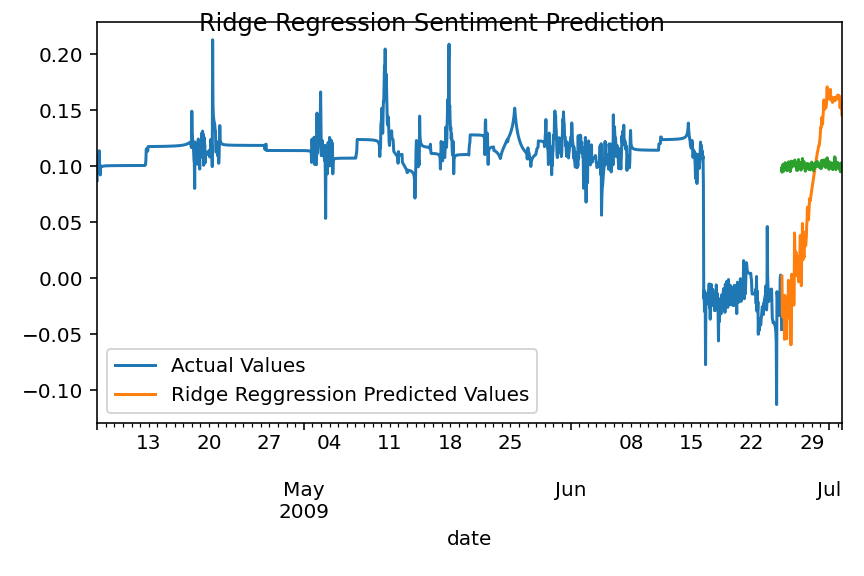

In [61]:
layout.servable()

In [37]:
predicted1 = LSTMPredict(24)

[[-0.04007105 -0.03935575 -0.03990039 -0.04060786 -0.04156518 -0.04293605
  -0.04507089 -0.04888791 -0.05788449 -0.11297094 -0.01209773 -0.01468546
  -0.02175243 -0.01408493 -0.02200589 -0.02818494 -0.01984162 -0.03346991
  -0.02432823 -0.00061636  0.00277359 -0.02582668 -0.01211965 -0.04594112]]
[[-0.03935575 -0.03990039 -0.04060786 -0.04156518 -0.04293605 -0.04507089
  -0.04888791 -0.05788449 -0.11297094 -0.01209773 -0.01468546 -0.02175243
  -0.01408493 -0.02200589 -0.02818494 -0.01984162 -0.03346991 -0.02432823
  -0.00061636  0.00277359 -0.02582668 -0.01211965 -0.04594112 -0.01953293]]
[[-0.03990039 -0.04060786 -0.04156518 -0.04293605 -0.04507089 -0.04888791
  -0.05788449 -0.11297094 -0.01209773 -0.01468546 -0.02175243 -0.01408493
  -0.02200589 -0.02818494 -0.01984162 -0.03346991 -0.02432823 -0.00061636
   0.00277359 -0.02582668 -0.01211965 -0.04594112 -0.01953293 -0.02052008]]
[[-0.04060786 -0.04156518 -0.04293605 -0.04507089 -0.04888791 -0.05788449
  -0.11297094 -0.01209773 -0.014

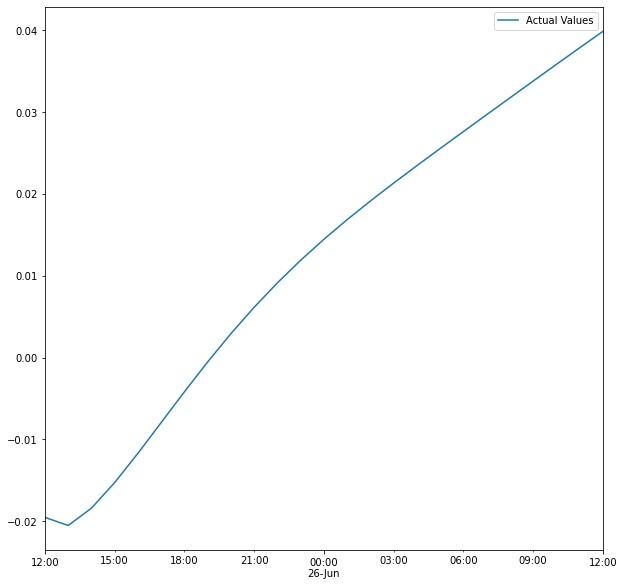

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
predicted1['average_sentiment_knn'].plot(label="Actual Values", ax=ax)
ax.legend()

plt.show()

In [32]:
predicted1.head()

,average_sentiment_knn
2009-06-25 12:00:00,-0.019533
2009-06-25 13:00:00,-0.020520
2009-06-25 14:00:00,-0.018404
2009-06-25 15:00:00,-0.015273
2009-06-25 16:00:00,-0.011697
